In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 13.5 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_mri"
DATASET = "masoudnickparvar/brain-tumor-mri-dataset"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
Dataset downloaded to: brain_tumor_mri


In [4]:
from pathlib import Path

TRAIN_DIR = Path(DATA_DIR) / "Training"

class_map = {
    "glioma": 0,
    "meningioma": 1,
    "notumor": 2,
    "pituitary": 3
}

paths, labels = [], []

for class_name, class_id in class_map.items():
    class_dir = TRAIN_DIR / class_name
    for img_path in class_dir.glob("*"):
        if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            paths.append(str(img_path))
            labels.append(class_id)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

num_classes = len(class_map)

print("Total images:", len(df))
print("Classes:", class_map)


Total images: 5600
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [5]:
train_df, test_df = train_test_split(
    df, stratify=df.label, test_size=0.2, random_state=42
)

train_df, val_df = train_test_split(
    train_df, stratify=train_df.label, test_size=0.2, random_state=42
)


In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [8]:
train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16,
    num_workers=0
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16,
    num_workers=0
)


In [9]:
model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)

summary(model, input_size=(1,3,224,224))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 4]                    152,064
├─PatchEmbed: 1-1                        [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Identity: 2-2                     [1, 196, 768]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Identity: 1-3                          [1, 197, 768]             --
├─Identity: 1-4                          [1, 197, 768]             --
├─Sequential: 1-5                        [1, 197, 768]             --
│    └─Block: 2-3                        [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             1,536
│    │    └─Attention: 3-2               [1, 197, 768]             2,362,368
│    │    └─Identity: 3-3                [1, 197, 768]             --
│    │    └─Identity: 3-4                [1, 197, 768]           

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [11]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [12]:
from PIL import Image


In [13]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{EPOCHS}]")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(f"\n===== Epoch {epoch+1} TRAIN =====")
    print(f"Loss: {train_loss:.4f}")
    print(f"Acc: {train_out['acc']:.4f} | Prec: {train_out['precision']:.4f} | "
          f"Recall: {train_out['recall']:.4f} | F1: {train_out['f1']:.4f}")
    print(f"Spec: {train_spec:.4f} | Sens: {train_sens:.4f} | "
          f"MCC: {train_out['mcc']:.4f} | AUC: {train_out['auc']:.4f}")

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validating"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k: v.compute().item() for k, v in val_metrics.items()}

    print(f"\n===== Epoch {epoch+1} VALID =====")
    print(f"Loss: {val_loss:.4f}")
    print(f"Acc: {val_out['acc']:.4f} | Prec: {val_out['precision']:.4f} | "
          f"Recall: {val_out['recall']:.4f} | F1: {val_out['f1']:.4f}")
    print(f"Spec: {val_spec:.4f} | Sens: {val_sens:.4f} | "
          f"MCC: {val_out['mcc']:.4f} | AUC: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    # ================= SAVE HISTORY =================
    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_out["acc"])
    history["val_accuracy"].append(val_out["acc"])
    history["precision"].append(train_out["precision"])
    history["val_precision"].append(val_out["precision"])
    history["recall"].append(train_out["recall"])
    history["val_recall"].append(val_out["recall"])
    history["f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["specificity"].append(train_spec)
    history["val_specificity"].append(val_spec)
    history["sensitivity"].append(train_sens)
    history["val_sensitivity"].append(val_sens)
    history["mcc"].append(train_out["mcc"])
    history["val_mcc"].append(val_out["mcc"])
    history["auc"].append(train_out["auc"])
    history["val_auc"].append(val_out["auc"])

    # ================= EARLY STOPPING =================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_vit_44c.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training - Epoch [1/30]: 100%|██████████| 224/224 [02:24<00:00,  1.55it/s]



===== Epoch 1 TRAIN =====
Loss: 1.2679
Acc: 0.4693 | Prec: 0.4699 | Recall: 0.4693 | F1: 0.4684
Spec: 0.8231 | Sens: 0.4693 | MCC: 0.2929 | AUC: 0.7145


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.90it/s]



===== Epoch 1 VALID =====
Loss: 0.9870
Acc: 0.5915 | Prec: 0.6463 | Recall: 0.5915 | F1: 0.5841
Spec: 0.8638 | Sens: 0.5915 | MCC: 0.4802 | AUC: 0.8527
Current LR: 5.000000e-04



Training - Epoch [2/30]: 100%|██████████| 224/224 [02:24<00:00,  1.55it/s]



===== Epoch 2 TRAIN =====
Loss: 0.8868
Acc: 0.6479 | Prec: 0.6466 | Recall: 0.6479 | F1: 0.6470
Spec: 0.8826 | Sens: 0.6479 | MCC: 0.5307 | AUC: 0.8558


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.92it/s]



===== Epoch 2 VALID =====
Loss: 0.7919
Acc: 0.6953 | Prec: 0.7314 | Recall: 0.6953 | F1: 0.7019
Spec: 0.8984 | Sens: 0.6953 | MCC: 0.6025 | AUC: 0.9014
Current LR: 4.986305e-04



Training - Epoch [3/30]: 100%|██████████| 224/224 [02:24<00:00,  1.55it/s]



===== Epoch 3 TRAIN =====
Loss: 0.6991
Acc: 0.7294 | Prec: 0.7283 | Recall: 0.7294 | F1: 0.7285
Spec: 0.9098 | Sens: 0.7294 | MCC: 0.6393 | AUC: 0.9096


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.93it/s]



===== Epoch 3 VALID =====
Loss: 0.7090
Acc: 0.7254 | Prec: 0.7395 | Recall: 0.7254 | F1: 0.7124
Spec: 0.9085 | Sens: 0.7254 | MCC: 0.6470 | AUC: 0.9195
Current LR: 4.945369e-04



Training - Epoch [4/30]: 100%|██████████| 224/224 [02:24<00:00,  1.55it/s]



===== Epoch 4 TRAIN =====
Loss: 0.6433
Acc: 0.7522 | Prec: 0.7496 | Recall: 0.7522 | F1: 0.7506
Spec: 0.9174 | Sens: 0.7522 | MCC: 0.6699 | AUC: 0.9215


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.94it/s]



===== Epoch 4 VALID =====
Loss: 0.6413
Acc: 0.7690 | Prec: 0.7894 | Recall: 0.7690 | F1: 0.7557
Spec: 0.9230 | Sens: 0.7690 | MCC: 0.7041 | AUC: 0.9375
Current LR: 4.877641e-04



Training - Epoch [5/30]: 100%|██████████| 224/224 [02:24<00:00,  1.55it/s]



===== Epoch 5 TRAIN =====
Loss: 0.5489
Acc: 0.7924 | Prec: 0.7912 | Recall: 0.7924 | F1: 0.7916
Spec: 0.9308 | Sens: 0.7924 | MCC: 0.7233 | AUC: 0.9417


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.92it/s]



===== Epoch 5 VALID =====
Loss: 0.6308
Acc: 0.7567 | Prec: 0.7810 | Recall: 0.7567 | F1: 0.7602
Spec: 0.9189 | Sens: 0.7567 | MCC: 0.6815 | AUC: 0.9401
Current LR: 4.783864e-04



Training - Epoch [6/30]: 100%|██████████| 224/224 [02:25<00:00,  1.54it/s]



===== Epoch 6 TRAIN =====
Loss: 0.5568
Acc: 0.7846 | Prec: 0.7827 | Recall: 0.7846 | F1: 0.7834
Spec: 0.9282 | Sens: 0.7846 | MCC: 0.7129 | AUC: 0.9391


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.91it/s]



===== Epoch 6 VALID =====
Loss: 0.6855
Acc: 0.7042 | Prec: 0.7676 | Recall: 0.7042 | F1: 0.7116
Spec: 0.9014 | Sens: 0.7042 | MCC: 0.6227 | AUC: 0.9298
Current LR: 4.665064e-04



Training - Epoch [7/30]: 100%|██████████| 224/224 [02:24<00:00,  1.55it/s]



===== Epoch 7 TRAIN =====
Loss: 0.5123
Acc: 0.8013 | Prec: 0.7994 | Recall: 0.8013 | F1: 0.8001
Spec: 0.9338 | Sens: 0.8013 | MCC: 0.7353 | AUC: 0.9485


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.89it/s]



===== Epoch 7 VALID =====
Loss: 0.6272
Acc: 0.7846 | Prec: 0.7923 | Recall: 0.7846 | F1: 0.7677
Spec: 0.9282 | Sens: 0.7846 | MCC: 0.7232 | AUC: 0.9474
Current LR: 4.522542e-04



Training - Epoch [8/30]: 100%|██████████| 224/224 [02:24<00:00,  1.55it/s]



===== Epoch 8 TRAIN =====
Loss: 0.4481
Acc: 0.8340 | Prec: 0.8325 | Recall: 0.8340 | F1: 0.8331
Spec: 0.9447 | Sens: 0.8340 | MCC: 0.7788 | AUC: 0.9597


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.92it/s]



===== Epoch 8 VALID =====
Loss: 0.5538
Acc: 0.7935 | Prec: 0.8082 | Recall: 0.7935 | F1: 0.7896
Spec: 0.9312 | Sens: 0.7935 | MCC: 0.7310 | AUC: 0.9523
Current LR: 4.357862e-04



Training - Epoch [9/30]: 100%|██████████| 224/224 [02:25<00:00,  1.54it/s]



===== Epoch 9 TRAIN =====
Loss: 0.4313
Acc: 0.8373 | Prec: 0.8358 | Recall: 0.8373 | F1: 0.8362
Spec: 0.9458 | Sens: 0.8373 | MCC: 0.7833 | AUC: 0.9625


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.92it/s]



===== Epoch 9 VALID =====
Loss: 0.5911
Acc: 0.7701 | Prec: 0.8064 | Recall: 0.7701 | F1: 0.7695
Spec: 0.9234 | Sens: 0.7701 | MCC: 0.7038 | AUC: 0.9497
Current LR: 4.172827e-04



Training - Epoch [10/30]: 100%|██████████| 224/224 [02:24<00:00,  1.55it/s]



===== Epoch 10 TRAIN =====
Loss: 0.3698
Acc: 0.8574 | Prec: 0.8562 | Recall: 0.8574 | F1: 0.8565
Spec: 0.9525 | Sens: 0.8574 | MCC: 0.8101 | AUC: 0.9711


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.95it/s]



===== Epoch 10 VALID =====
Loss: 0.5042
Acc: 0.8248 | Prec: 0.8317 | Recall: 0.8248 | F1: 0.8241
Spec: 0.9416 | Sens: 0.8248 | MCC: 0.7689 | AUC: 0.9570
Current LR: 3.969463e-04



Training - Epoch [11/30]: 100%|██████████| 224/224 [02:25<00:00,  1.54it/s]



===== Epoch 11 TRAIN =====
Loss: 0.3508
Acc: 0.8624 | Prec: 0.8616 | Recall: 0.8624 | F1: 0.8620
Spec: 0.9541 | Sens: 0.8624 | MCC: 0.8166 | AUC: 0.9739


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.94it/s]



===== Epoch 11 VALID =====
Loss: 0.4992
Acc: 0.8181 | Prec: 0.8241 | Recall: 0.8181 | F1: 0.8173
Spec: 0.9394 | Sens: 0.8181 | MCC: 0.7598 | AUC: 0.9564
Current LR: 3.750000e-04



Training - Epoch [12/30]: 100%|██████████| 224/224 [02:25<00:00,  1.54it/s]



===== Epoch 12 TRAIN =====
Loss: 0.3022
Acc: 0.8856 | Prec: 0.8849 | Recall: 0.8856 | F1: 0.8852
Spec: 0.9619 | Sens: 0.8856 | MCC: 0.8475 | AUC: 0.9800


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.91it/s]



===== Epoch 12 VALID =====
Loss: 0.4666
Acc: 0.8426 | Prec: 0.8457 | Recall: 0.8426 | F1: 0.8433
Spec: 0.9475 | Sens: 0.8426 | MCC: 0.7908 | AUC: 0.9597
Current LR: 3.516842e-04



Training - Epoch [13/30]: 100%|██████████| 224/224 [02:25<00:00,  1.54it/s]



===== Epoch 13 TRAIN =====
Loss: 0.2500
Acc: 0.9062 | Prec: 0.9057 | Recall: 0.9062 | F1: 0.9059
Spec: 0.9687 | Sens: 0.9062 | MCC: 0.8751 | AUC: 0.9858


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.91it/s]



===== Epoch 13 VALID =====
Loss: 0.4449
Acc: 0.8493 | Prec: 0.8507 | Recall: 0.8493 | F1: 0.8493
Spec: 0.9498 | Sens: 0.8493 | MCC: 0.7996 | AUC: 0.9642
Current LR: 3.272542e-04



Training - Epoch [14/30]: 100%|██████████| 224/224 [02:25<00:00,  1.54it/s]



===== Epoch 14 TRAIN =====
Loss: 0.2275
Acc: 0.9155 | Prec: 0.9152 | Recall: 0.9155 | F1: 0.9152
Spec: 0.9718 | Sens: 0.9155 | MCC: 0.8874 | AUC: 0.9885


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.93it/s]



===== Epoch 14 VALID =====
Loss: 0.8198
Acc: 0.7511 | Prec: 0.8004 | Recall: 0.7511 | F1: 0.7537
Spec: 0.9170 | Sens: 0.7511 | MCC: 0.6789 | AUC: 0.9425
Current LR: 3.019779e-04



Training - Epoch [15/30]: 100%|██████████| 224/224 [02:25<00:00,  1.54it/s]



===== Epoch 15 TRAIN =====
Loss: 0.2397
Acc: 0.9096 | Prec: 0.9095 | Recall: 0.9096 | F1: 0.9095
Spec: 0.9699 | Sens: 0.9096 | MCC: 0.8795 | AUC: 0.9870


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.93it/s]



===== Epoch 15 VALID =====
Loss: 0.5679
Acc: 0.8047 | Prec: 0.8153 | Recall: 0.8047 | F1: 0.8044
Spec: 0.9349 | Sens: 0.8047 | MCC: 0.7429 | AUC: 0.9526
Current LR: 2.761321e-04



Training - Epoch [16/30]: 100%|██████████| 224/224 [02:23<00:00,  1.56it/s]



===== Epoch 16 TRAIN =====
Loss: 0.1926
Acc: 0.9289 | Prec: 0.9286 | Recall: 0.9289 | F1: 0.9286
Spec: 0.9763 | Sens: 0.9289 | MCC: 0.9052 | AUC: 0.9912


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.92it/s]



===== Epoch 16 VALID =====
Loss: 0.6566
Acc: 0.7980 | Prec: 0.7991 | Recall: 0.7980 | F1: 0.7899
Spec: 0.9327 | Sens: 0.7980 | MCC: 0.7357 | AUC: 0.9491
Current LR: 2.500000e-04



Training - Epoch [17/30]: 100%|██████████| 224/224 [02:23<00:00,  1.56it/s]



===== Epoch 17 TRAIN =====
Loss: 0.1531
Acc: 0.9411 | Prec: 0.9409 | Recall: 0.9411 | F1: 0.9409
Spec: 0.9804 | Sens: 0.9411 | MCC: 0.9216 | AUC: 0.9944


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.85it/s]



===== Epoch 17 VALID =====
Loss: 0.5734
Acc: 0.8114 | Prec: 0.8192 | Recall: 0.8114 | F1: 0.8124
Spec: 0.9371 | Sens: 0.8114 | MCC: 0.7503 | AUC: 0.9544
Current LR: 2.238679e-04



Training - Epoch [18/30]: 100%|██████████| 224/224 [02:25<00:00,  1.54it/s]



===== Epoch 18 TRAIN =====
Loss: 0.1239
Acc: 0.9584 | Prec: 0.9584 | Recall: 0.9584 | F1: 0.9584
Spec: 0.9861 | Sens: 0.9584 | MCC: 0.9446 | AUC: 0.9963


Validating: 100%|██████████| 56/56 [00:14<00:00,  3.88it/s]


===== Epoch 18 VALID =====
Loss: 0.7453
Acc: 0.8181 | Prec: 0.8297 | Recall: 0.8181 | F1: 0.8191
Spec: 0.9394 | Sens: 0.8181 | MCC: 0.7605 | AUC: 0.9520
Current LR: 1.980221e-04

Early stopping triggered.


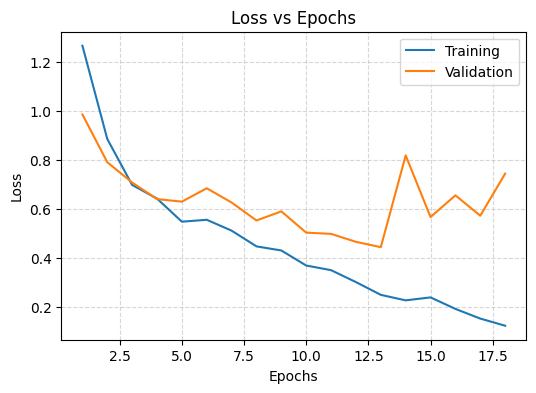

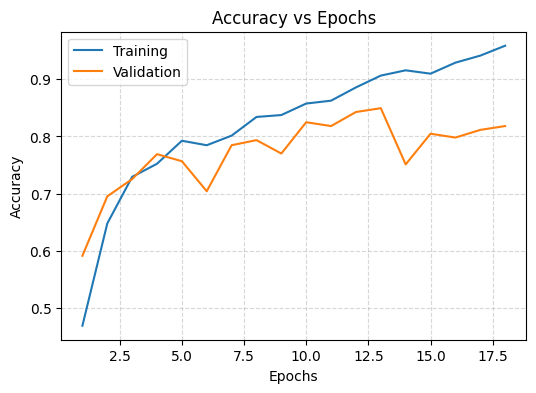

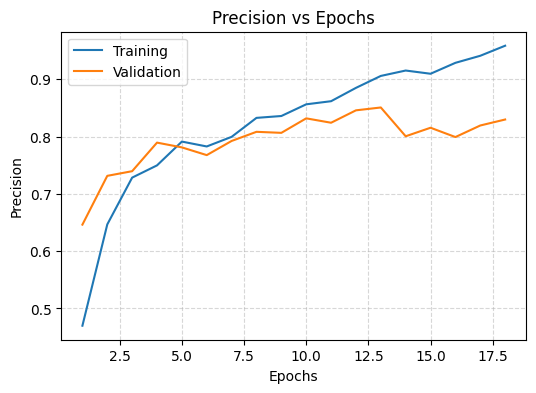

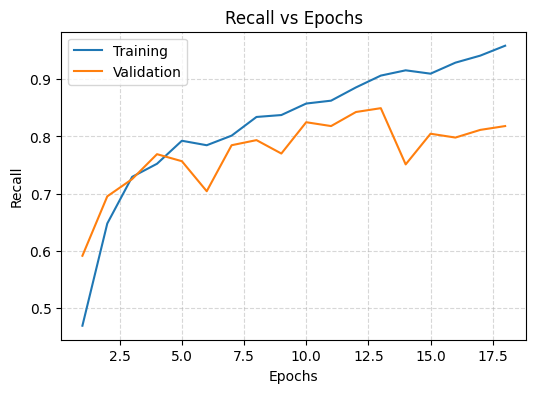

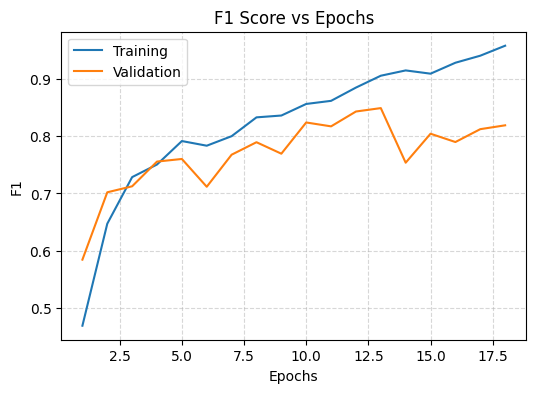

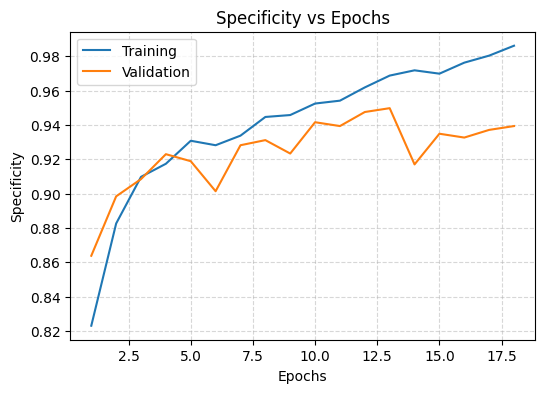

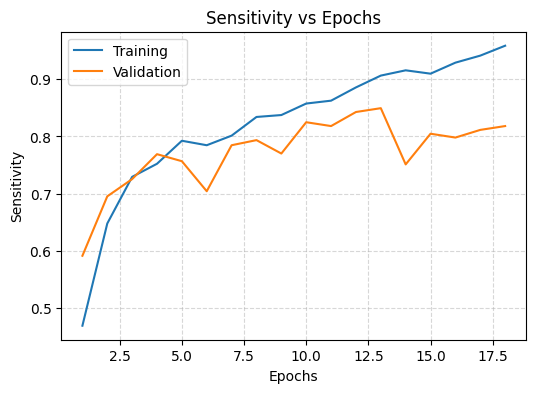

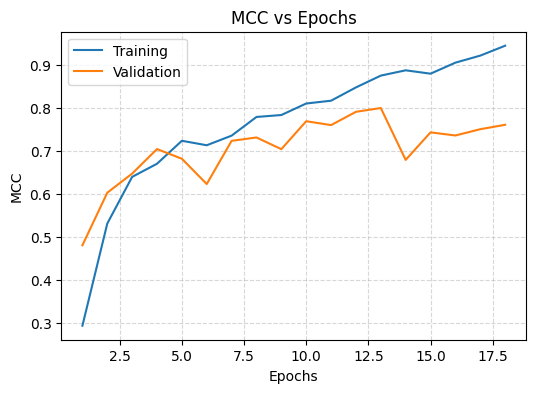

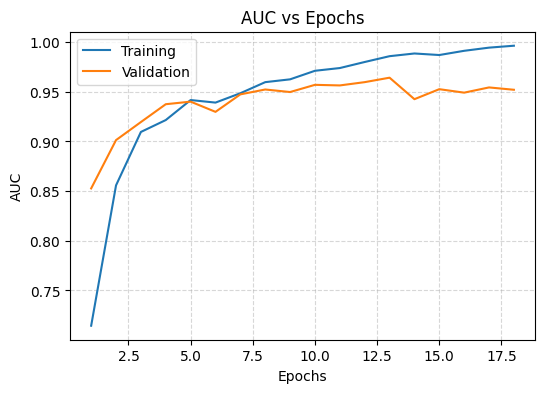

In [14]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [15]:
# Load best model
model.load_state_dict(torch.load("best_vit_44c.pth"))

model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [16]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 70/70 [00:17<00:00,  3.91it/s]


===== TEST RESULTS =====
Test Loss: 0.4542
ACC: 0.8429
PRECISION: 0.8434
RECALL: 0.8429
F1: 0.8426
AUC: 0.9638
MCC: 0.7908


In [17]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.8272    0.8036    0.8152       280
           1     0.7439    0.7571    0.7504       280
           2     0.8896    0.9500    0.9188       280
           3     0.9129    0.8607    0.8860       280

    accuracy                         0.8429      1120
   macro avg     0.8434    0.8429    0.8426      1120
weighted avg     0.8434    0.8429    0.8426      1120



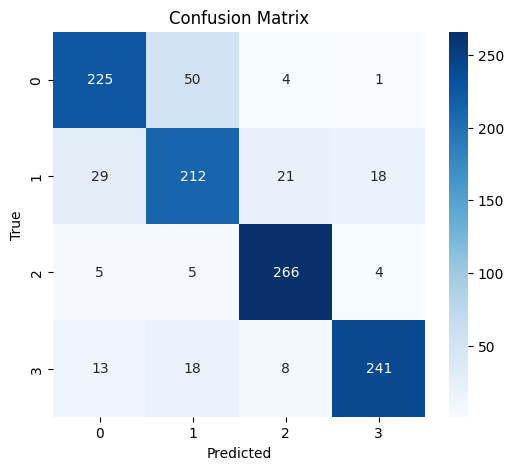

In [18]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [19]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


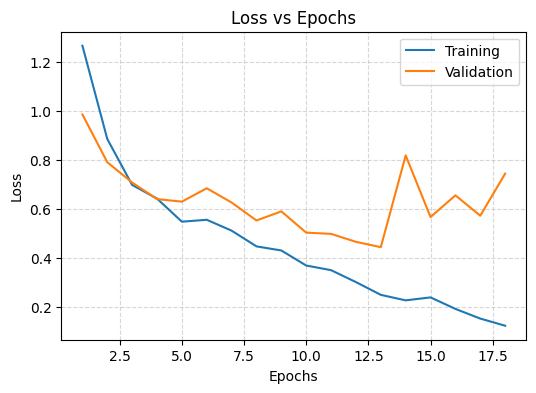

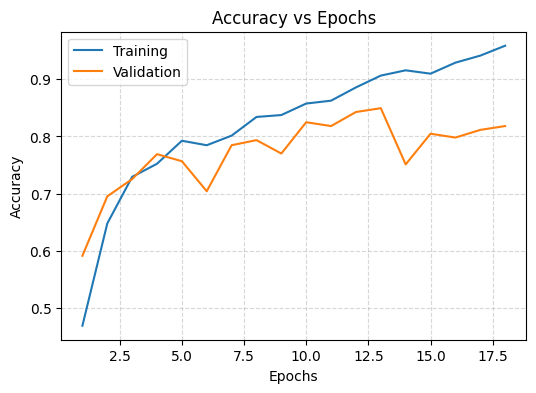

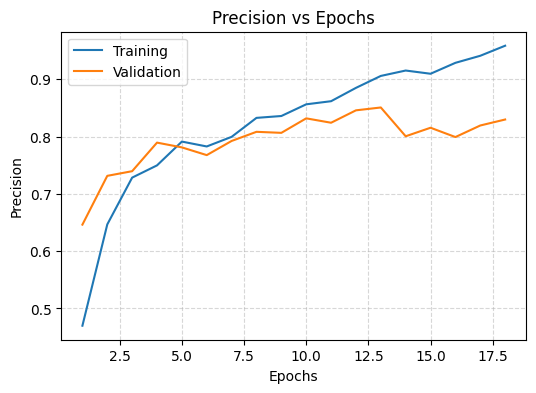

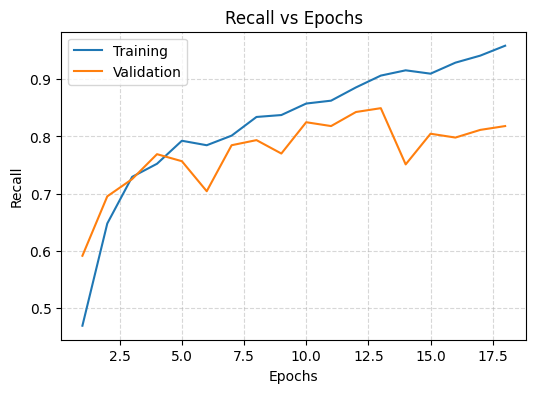

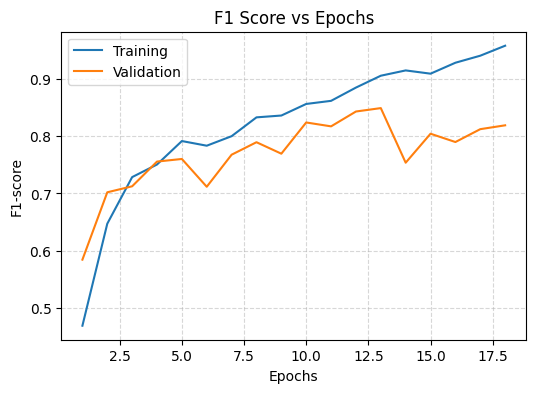

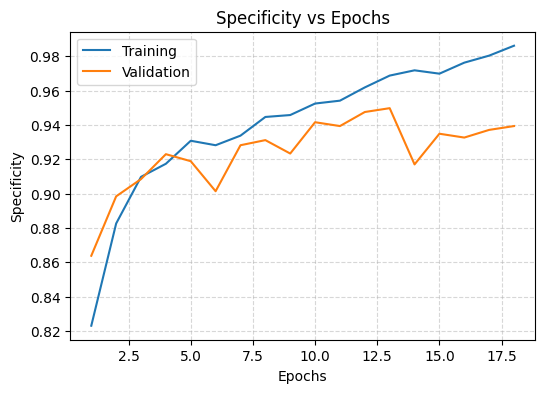

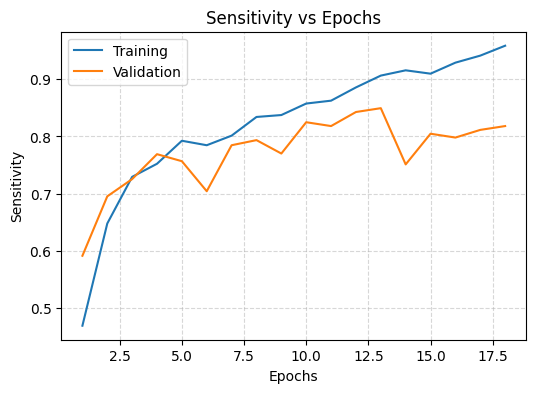

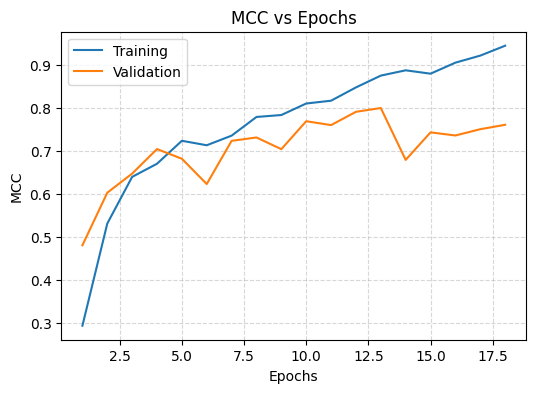

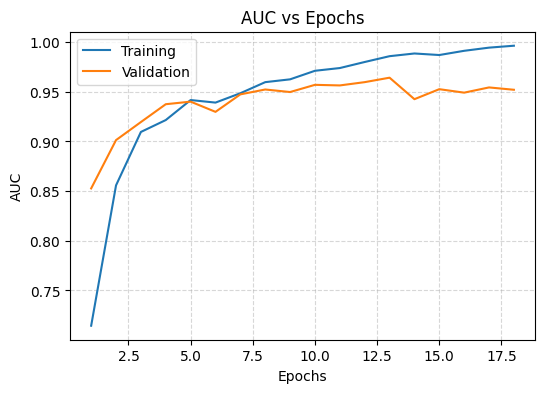

In [20]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
